# CSE527 Homework 5 Part 2
**Due date: 11:59 pm EST on May 9, 2022 (Monday)**

In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your Stony Brook (*.stonybrook.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

Settings used for assignments: ***Edit -> Notebook Settings -> Runtime Type (Python 3)***.


## Description
---
Detection is a fundamental task in CV. This homework is on faster-RCNN, one of the most famous two-stage detection models. You will first implement some basic functions of detection, including generating anchor boxes of different scales and ratios and calculating iou. Then you will train and test on the UAVDT dataset with faster-RCNN ([faster-rcnn.pytorch](https://github.com/jwyang/faster-rcnn.pytorch)) to see how a detection model really works.

The UAVDT dataset ("data_uav.tar.gz") and the pretrained faster-RCNN model ("data/pretrained_model/vgg16_caffe.pth") are in https://drive.google.com/drive/folders/1zEDPAKjv2gk2ivhsLZlMDVgCqI0se-lN?usp=sharing. Please copy the "data_uav.tar.gz" to "CSE527-22S-HW5/" and copy the "data" folder to "CSE527-22S-HW5/faster-rcnn.pytorch/".

The code of this homework strictly relies on the right version of some libraries. DO NOT change anything except cells you are required to fill in. 

## Setup Environment
---



In [1]:
# remember to RESTART runtime when you see prompt asking to do so
!pip install torch==1.3.0+cu100 torchvision==0.4.1+cu100 -f https://download.pytorch.org/whl/torch_stable.html
!pip install Pillow==6.2.2
!pip install scipy==1.2.1

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [2]:
import torch
print(torch.__version__)

1.3.0+cu100


In [3]:
import xml.etree.ElementTree as ET
import scipy.sparse
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np

In [4]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
% cd "/content/gdrive/MyDrive/Wang_Hong_113263916_hw/Wang_Hong_113263916_hw5/"

/content/gdrive/MyDrive/hw5


In [6]:
!tar -xvf data_uav.tar.gz -C faster-rcnn.pytorch/

data/
data/pretrained_model/
data/VOCdevkit2007/
data/VOCdevkit2007/annotations_cache/
data/VOCdevkit2007/UAV2017/
data/VOCdevkit2007/UAV2017/ImageSets/
data/VOCdevkit2007/UAV2017/ImageSets/Main/
data/VOCdevkit2007/UAV2017/ImageSets/Main/trainval.txt
data/VOCdevkit2007/UAV2017/ImageSets/Main/test.txt
data/VOCdevkit2007/UAV2017/JPEGImages/
data/VOCdevkit2007/UAV2017/JPEGImages/M0203_313.jpg
data/VOCdevkit2007/UAV2017/JPEGImages/M0203_67.jpg
data/VOCdevkit2007/UAV2017/JPEGImages/M0203_489.jpg
data/VOCdevkit2007/UAV2017/JPEGImages/M0101_5.jpg
data/VOCdevkit2007/UAV2017/JPEGImages/M0201_359.jpg
data/VOCdevkit2007/UAV2017/JPEGImages/M0201_999.jpg
data/VOCdevkit2007/UAV2017/JPEGImages/M0201_419.jpg
data/VOCdevkit2007/UAV2017/JPEGImages/M0201_667.jpg
data/VOCdevkit2007/UAV2017/JPEGImages/M0203_259.jpg
data/VOCdevkit2007/UAV2017/JPEGImages/M0203_85.jpg
data/VOCdevkit2007/UAV2017/JPEGImages/M0201_557.jpg
data/VOCdevkit2007/UAV2017/JPEGImages/M0201_903.jpg
data/VOCdevkit2007/UAV2017/JPEGImages/M

In [7]:
!wget -P faster-rcnn.pytorch/data/pretrained_model https://drive.google.com/file/d/18bG6Uu4TWrBbWyLl-Dm6c3yb1Vt6u4Eh/view?usp=sharing

--2022-05-10 01:55:15--  https://drive.google.com/file/d/18bG6Uu4TWrBbWyLl-Dm6c3yb1Vt6u4Eh/view?usp=sharing
Resolving drive.google.com (drive.google.com)... 74.125.141.101, 74.125.141.102, 74.125.141.100, ...
Connecting to drive.google.com (drive.google.com)|74.125.141.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘faster-rcnn.pytorch/data/pretrained_model/view?usp=sharing.3’

view?usp=sharing.3      [ <=>                ]  62.49K  --.-KB/s    in 0.004s  

2022-05-10 01:55:15 (14.5 MB/s) - ‘faster-rcnn.pytorch/data/pretrained_model/view?usp=sharing.3’ saved [63994]



In [8]:
%cd faster-rcnn.pytorch

/content/gdrive/MyDrive/hw5/faster-rcnn.pytorch


In [9]:
!pip install -r requirements.txt

     |████████████████████████████████| 125 kB 5.0 MB/s 


In [10]:
%cd lib 

/content/gdrive/MyDrive/hw5/faster-rcnn.pytorch/lib


In [11]:
!rm -rf build

In [12]:
!python setup.py build develop

running build
running build_py
creating build
creating build/lib.linux-x86_64-3.7
creating build/lib.linux-x86_64-3.7/pycocotools
copying pycocotools/mask.py -> build/lib.linux-x86_64-3.7/pycocotools
copying pycocotools/__init__.py -> build/lib.linux-x86_64-3.7/pycocotools
copying pycocotools/cocoeval.py -> build/lib.linux-x86_64-3.7/pycocotools
copying pycocotools/coco.py -> build/lib.linux-x86_64-3.7/pycocotools
creating build/lib.linux-x86_64-3.7/datasets
copying datasets/pascal_voc_rbg.py -> build/lib.linux-x86_64-3.7/datasets
copying datasets/pascal_voc.py -> build/lib.linux-x86_64-3.7/datasets
copying datasets/ds_utils.py -> build/lib.linux-x86_64-3.7/datasets
copying datasets/imagenet.py -> build/lib.linux-x86_64-3.7/datasets
copying datasets/coco.py -> build/lib.linux-x86_64-3.7/datasets
copying datasets/factory.py -> build/lib.linux-x86_64-3.7/datasets
copying datasets/imdb.py -> build/lib.linux-x86_64-3.7/datasets
copying datasets/vg.py -> build/lib.linux-x86_64-3.7/datasets


In [13]:
%cd ..

/content/gdrive/MyDrive/hw5/faster-rcnn.pytorch


15 ground-truth bounding boxes in all
bbox0: [141 147 247 192] class: car
bbox1: [ 26 179  67 203] class: car
bbox2: [221 232 264 258] class: car
bbox3: [367 235 405 266] class: car
bbox4: [565 154 596 177] class: car
bbox5: [689 158 718 176] class: car
bbox6: [751 130 794 161] class: car
bbox7: [436 271 472 306] class: car
bbox8: [523 288 560 330] class: car
bbox9: [542 275 576 314] class: car
bbox10: [548 329 584 370] class: car
bbox11: [ 62 250 110 271] class: car
bbox12: [ 45 229  93 249] class: car
bbox13: [588 377 627 420] class: car
bbox14: [666 487 713 537] class: car


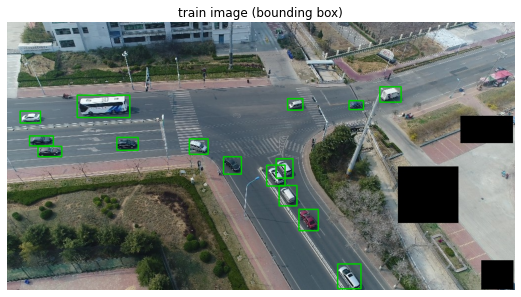

In [14]:
# get ground-truth annotation

def load_pascal_annotation(data_path, index, num_classes):
  """
  Load image and bounding boxes info from XML file in the PASCAL VOC
  format.
  """
  filename = os.path.join(data_path, 'Annotations', index + '.xml')
  tree = ET.parse(filename)
  objs = tree.findall('object')

  # Exclude the samples labeled as difficult
  non_diff_objs = [
      obj for obj in objs if int(obj.find('difficult').text) == 0]
  if len(non_diff_objs) != len(objs):
      print('Removed {} difficult objects'.format(
          len(objs) - len(non_diff_objs)))
  objs = non_diff_objs
  num_objs = len(objs)

  boxes = np.zeros((num_objs, 4), dtype=np.uint16)
  gt_classes = [i for i in range(num_objs)]

  # Load object bounding boxes into a data frame.
  for ix, obj in enumerate(objs):
      bbox = obj.find('bndbox')
      # Make pixel indexes 0-based
      x1 = float(bbox.find('xmin').text) - 1
      y1 = float(bbox.find('ymin').text) - 1
      x2 = float(bbox.find('xmax').text) - 1
      y2 = float(bbox.find('ymax').text) - 1
      cls = obj.find('name').text.lower().strip()
      boxes[ix, :] = [x1, y1, x2, y2]
      gt_classes[ix] = cls

  return {'boxes' : boxes,
          'gt_classes': gt_classes}

# plot bounding box on image
def vis_detections(im, bbox, color=(0, 204, 0), clip=None, width=2):
  im_ = np.copy(im)
  for i in range(len(bbox)):
    cv2.rectangle(im_, (int(bbox[i][0]),int(bbox[i][1])), (int(bbox[i][2]),int(bbox[i][3])), color, width)

  # Be sure to convert the color space of the image from
  # BGR (Opencv) to RGB (Matplotlib) before you show a 
  # color image read from OpenCV
  plt.figure(figsize=(20, 10));
  plt.subplot(1, 2, 1);
  if clip is not None:
    plt.imshow(cv2.cvtColor(im_[clip[0]:clip[2],clip[1]:clip[3],:], cv2.COLOR_BGR2RGB));
  else:
    plt.imshow(cv2.cvtColor(im_, cv2.COLOR_BGR2RGB));
  plt.title('train image (bounding box)');
  plt.axis("off");
  
  return im_

# read the image for local directory (same with this .ipynb) 
img = cv2.imread('images/img0.jpg')

data_path = 'data/VOCdevkit2007/UAV2017/'
index = 'M0101_1'
gt = load_pascal_annotation(data_path, index, 2)

print("{} ground-truth bounding boxes in all".format(len(gt['boxes'])))
for _i in range(len(gt['boxes'])):
  print('bbox{}: {} class: {}'.format(_i, gt['boxes'][_i],gt['gt_classes'][_i]))

img_gt = vis_detections(img, gt['boxes'])



## Problem 1: Basic functions
(30 points) You will first implement two basic functions in detection, generating anchor boxes of different scales and ratios. Then you will calculate the Intersection over Union (iou) between the ground-truth bounding boxes and your generated anchor boxes. Finally, you will do ROI pooling to get feature map of fixed size. For more information about anchor boxes and iou, you can refer to https://d2l.ai/chapter_computer-vision/anchor.html or other online materials.

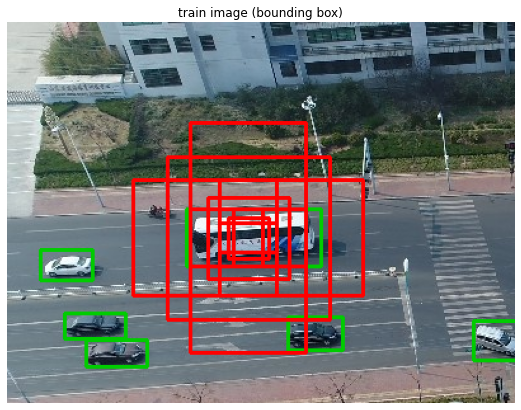

In [15]:
# generate anchor boxes of different scales and ratios
def generate_anchors(center, scales, ratios, base_size=4):  
    # base_size is your anchor box size when scale=1 and ratio=1
    ##########--WRITE YOUR CODE HERE--########## 
    
    anchors = []
    for i in range(len(scales)):
      for j in range(len(ratios)):
        width = base_size * scales[i] * np.sqrt(ratios[j])
        height = (base_size * scales[i]) / np.sqrt(ratios[j])
    
        x1 = int(center[0] - width/2)
        y1 = int(center[1] - height/2)

        x2 = int(center[0] + width/2)
        y2 = int(center[1] + height/2)

        anchors.append(np.array([x1,y1,x2,y2]))

    anchors = np.array(anchors)
    
    ##########-------END OF CODE-------########## 
    return anchors

center = [190, 170]
anchor_scales = [8, 16, 32]
anchor_ratios = [0.5, 1, 2]

bbox = generate_anchors(center, anchor_scales, anchor_ratios)

# crop image for better view
img_gt_a = vis_detections(img_gt, bbox, (0,0,255), (0,0,300,400))

gt:[141, 147, 247, 192]  bbox:[178 147 201 192]  iou:0.2170
gt:[141, 147, 247, 192]  bbox:[174 154 206 186]  iou:0.2147
gt:[141, 147, 247, 192]  bbox:[167 158 212 181]  iou:0.2170
gt:[141, 147, 247, 192]  bbox:[144 147 235 192]  iou:0.8585
gt:[141, 147, 247, 192]  bbox:[144  79 235 260]  iou:0.2388


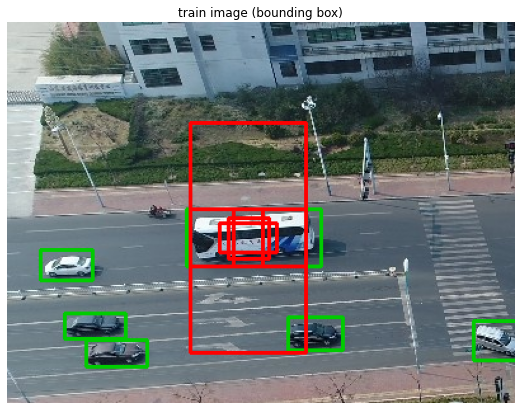

In [16]:
def bbox_iou(bbox_a, bbox_b):
    """Calculate the Intersection of Unions (IoUs) between bounding boxes.

    IoU is calculated as a ratio of area of the intersection
    and area of the union.

    both inputs and output should be python list
    """
    ##########--WRITE YOUR CODE HERE--##########
    
    iou = []
    for i in range(len(bbox_a)):
      iou_gt = []
      for j in range(len(bbox_b)):
        x1 = max(bbox_a[i][0], bbox_b[j][0])
        y1 = max(bbox_a[i][1], bbox_b[j][1])
        x2 = min(bbox_a[i][2], bbox_b[j][2])
        y2 = min(bbox_a[i][3], bbox_b[j][3])

        area = abs((x2 - x1) * (y2 - y1))

        area_a = abs( (bbox_a[i][0] - bbox_a[i][2]) * (bbox_a[i][1] - bbox_a[i][3]))
        area_b = abs( (bbox_b[j][0] - bbox_b[j][2]) * (bbox_b[j][1] - bbox_b[j][3]))

        true_area = area_a + area_b - area

        iou_gt.append(area / true_area)

      iou.append(iou_gt)
    
    iou = np.array(iou)

    ##########-------END OF CODE-------########## 
    return iou

bbox_gt = [[141,147,247,192]]
iou = bbox_iou(bbox_gt, bbox)
bbox_filter = []
iou_max = 0.0
bbox_max = None
for bbox_, iou_ in zip(bbox, iou[0]):
  # get bbox of maximum iou
  if iou_ > iou_max:
    iou_max = iou_
    bbox_max = bbox_
  # only keep bbox of high iou as postive and low iou as negative
  if iou_>=0.25 and iou_<=0.7:
    continue
  print("gt:{}  bbox:{}  iou:{:.4f}".format(bbox_gt[0], bbox_, iou_))
  bbox_filter.append(bbox_)

img_gt_b = vis_detections(img_gt, bbox_filter, (0,0,255), (0,0,300,400))

gt:[141, 147, 247, 192]  bbox_max:[144 147 235 192]  iou_max:0.8585
(25, 25, 3)
(25, 25, 3)


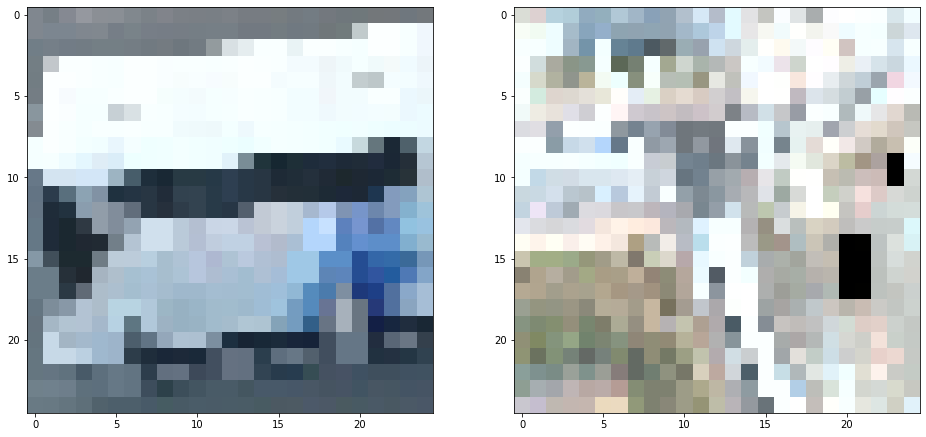

In [17]:
print("gt:{}  bbox_max:{}  iou_max:{:.4f}".format(bbox_gt[0], bbox_max, iou_max))

def roi_pooling(roi, pooling_shape):
  ##########--WRITE YOUR CODE HERE--##########
  # check the shape of roi first and pay attention to the channel dimension
  # Use numpy for the implementation in this block.
  # DON'T use torch or torchvision in this block.

  height, width, num_channels = roi.shape

  pooled_height = pooling_shape[1]
  pooled_width = pooling_shape[0]
  h_step = height/pooled_height
  w_step = width/pooled_width

  op = torch.ones((pooled_width, pooled_height, num_channels))
  for i in range(pooled_height):
    for j in range(pooled_width):
      for k in range(num_channels):

        h_start = min(height, max(0, int(np.floor(i * h_step))))
        w_start = min(width, max(0, int(np.floor(j * w_step))))
        h_end   = min(height, max(0, int(np.ceil((i+1) * h_step))))
        w_end   = min(width, max(0, int(np.ceil((j+1) * w_step))))

        patch_region = torch.Tensor(roi[h_start:h_end, w_start:w_end, k])
        maxV, maxI = torch.max(patch_region.reshape(1,-1), dim=1)
        op[i,j,k] = maxV


  roip = op.numpy().astype(np.uint8)

  ##########-------END OF CODE-------##########
  return roip

# pooling on anchor box of maximum iou
roi = img[bbox_max[1]:bbox_max[3],bbox_max[0]:bbox_max[2],:]
roip = roi_pooling(roi, (25,25)) 
print(roip.shape)

# pooling on whole image
imgp = roi_pooling(img, (25,25)) 
print(imgp.shape)

plt.figure(figsize=(16, 8));
plt.subplot(1, 2, 1);
plt.imshow(cv2.cvtColor(roip, cv2.COLOR_BGR2RGB));
plt.subplot(1, 2, 2);
plt.imshow(cv2.cvtColor(imgp, cv2.COLOR_BGR2RGB));

## Problem 2: Faster-RCNN

(20 points) Unmanned Aerial Vehicles (UAVs) are used to fuel numerous important applications in computer vision. This UAVDT dataset contains several videos of traffic. Each video is provided as a sequence of JPEG images. It only has one class of object, i.e., car. The subset contains only two videos for training and one video for testing, just to reduce time.  

You will train and test Faster-RCNN on the small subset. Actually, this part is so complicated that you **do not** have the opportunity to write any code. All you need is to run this section, output the correct detection result images, and make discussions. However, you are stil strongly recommended to understand the function of each part. You might encounter some strange errors, and in which situation, I would suggest you to check that the dataset has been successful extracted on google drive and restart your runtime.

Remember that you need to finish the **discussion** at the last part.

In [18]:
# --------------------------------------------------------
# Pytorch multi-GPU Faster R-CNN
# Licensed under The MIT License [see LICENSE for details]
# Written by Jiasen Lu, Jianwei Yang, based on code from Ross Girshick
# Modified by Tao for HW5
# --------------------------------------------------------
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths
import os
import sys
import numpy as np
import argparse
import pprint
import pdb
import time

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
from torch.utils.data.sampler import Sampler

from roi_data_layer.roidb import combined_roidb
from roi_data_layer.roibatchLoader import roibatchLoader
from model.utils.config import cfg, cfg_from_file, cfg_from_list, get_output_dir
from model.utils.net_utils import weights_normal_init, save_net, load_net, \
      adjust_learning_rate, save_checkpoint, clip_gradient

from model.faster_rcnn.vgg16 import vgg16
from model.faster_rcnn.resnet import resnet

def parse_args(args):
  """
  Parse input arguments
  """
  parser = argparse.ArgumentParser(description='Train a Fast R-CNN network')
  parser.add_argument('--dataset', dest='dataset',
                      help='training dataset',
                      default='pascal_voc', type=str)
  parser.add_argument('--net', dest='net',
                    help='vgg16, res101',
                    default='vgg16', type=str)
  parser.add_argument('--start_epoch', dest='start_epoch',
                      help='starting epoch',
                      default=1, type=int)
  parser.add_argument('--epochs', dest='max_epochs',
                      help='number of epochs to train',
                      default=20, type=int)
  parser.add_argument('--disp_interval', dest='disp_interval',
                      help='number of iterations to display',
                      default=100, type=int)
  parser.add_argument('--checkpoint_interval', dest='checkpoint_interval',
                      help='number of iterations to display',
                      default=10000, type=int)

  parser.add_argument('--save_dir', dest='save_dir',
                      help='directory to save models', default="models",
                      type=str)
  parser.add_argument('--nw', dest='num_workers',
                      help='number of workers to load data',
                      default=0, type=int)
  parser.add_argument('--cuda', dest='cuda',
                      help='whether use CUDA',
                      action='store_true')
  parser.add_argument('--ls', dest='large_scale',
                      help='whether use large imag scale',
                      action='store_true')                      
  parser.add_argument('--mGPUs', dest='mGPUs',
                      help='whether use multiple GPUs',
                      action='store_true')
  parser.add_argument('--bs', dest='batch_size',
                      help='batch_size',
                      default=1, type=int)
  parser.add_argument('--cag', dest='class_agnostic',
                      help='whether to perform class_agnostic bbox regression',
                      action='store_true')

# config optimization
  parser.add_argument('--o', dest='optimizer',
                      help='training optimizer',
                      default="sgd", type=str)
  parser.add_argument('--lr', dest='lr',
                      help='starting learning rate',
                      default=0.001, type=float)
  parser.add_argument('--lr_decay_step', dest='lr_decay_step',
                      help='step to do learning rate decay, unit is epoch',
                      default=5, type=int)
  parser.add_argument('--lr_decay_gamma', dest='lr_decay_gamma',
                      help='learning rate decay ratio',
                      default=0.1, type=float)

# set training session
  parser.add_argument('--s', dest='session',
                      help='training session',
                      default=1, type=int)

# resume trained model
  parser.add_argument('--r', dest='resume',
                      help='resume checkpoint or not',
                      default=False, type=bool)
  parser.add_argument('--checksession', dest='checksession',
                      help='checksession to load model',
                      default=1, type=int)
  parser.add_argument('--checkepoch', dest='checkepoch',
                      help='checkepoch to load model',
                      default=1, type=int)
  parser.add_argument('--checkpoint', dest='checkpoint',
                      help='checkpoint to load model',
                      default=0, type=int)
# log and display
  parser.add_argument('--use_tfb', dest='use_tfboard',
                      help='whether use tensorboard',
                      action='store_true')

  args = parser.parse_args(args)

  return args


class sampler(Sampler):
  def __init__(self, train_size, batch_size):
    self.num_data = train_size
    self.num_per_batch = int(train_size / batch_size)
    self.batch_size = batch_size
    self.range = torch.arange(0,batch_size).view(1, batch_size).long()
    self.leftover_flag = False
    if train_size % batch_size:
      self.leftover = torch.arange(self.num_per_batch*batch_size, train_size).long()
      self.leftover_flag = True

  def __iter__(self):
    rand_num = torch.randperm(self.num_per_batch).view(-1,1) * self.batch_size
    self.rand_num = rand_num.expand(self.num_per_batch, self.batch_size) + self.range

    self.rand_num_view = self.rand_num.view(-1)

    if self.leftover_flag:
      self.rand_num_view = torch.cat((self.rand_num_view, self.leftover),0)

    return iter(self.rand_num_view)

  def __len__(self):
    return self.num_data


# add your args here
args = parse_args(['--dataset','uav','--net','vgg16','--bs','8','--lr','1e-2','--lr_decay_step','4','--epochs','2','--cuda'])

print('Called with args:')
print(args)

args.imdb_name = "uav_2017_trainval"
args.imdbval_name = "uav_2017_test"
args.set_cfgs = ['ANCHOR_SCALES', '[8, 16, 32]', 'ANCHOR_RATIOS', '[0.5,1,2]', 'MAX_NUM_GT_BOXES', '20']


args.cfg_file = "cfgs/{}_ls.yml".format(args.net) if args.large_scale else "cfgs/{}.yml".format(args.net)

if args.cfg_file is not None:
  cfg_from_file(args.cfg_file)
if args.set_cfgs is not None:
  cfg_from_list(args.set_cfgs)

print('Using config:')
pprint.pprint(cfg)
np.random.seed(cfg.RNG_SEED)

#torch.backends.cudnn.benchmark = True
if torch.cuda.is_available() and not args.cuda:
  print("WARNING: You have a CUDA device, so you should probably run with --cuda")

# train set
# -- Note: Use validation set and disable the flipped to enable faster loading.
cfg.TRAIN.USE_FLIPPED = False
cfg.USE_GPU_NMS = args.cuda
imdb, roidb, ratio_list, ratio_index = combined_roidb(args.imdb_name)
train_size = len(roidb)

print('{:d} roidb entries'.format(len(roidb)))

output_dir = args.save_dir + "/" + args.net + "/" + args.dataset
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

sampler_batch = sampler(train_size, args.batch_size)

dataset = roibatchLoader(roidb, ratio_list, ratio_index, args.batch_size, \
                          imdb.num_classes, training=True)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=args.batch_size,
                          sampler=sampler_batch, num_workers=args.num_workers)

# initilize the tensor holder here.
im_data = torch.FloatTensor(1)
im_info = torch.FloatTensor(1)
num_boxes = torch.LongTensor(1)
gt_boxes = torch.FloatTensor(1)

# ship to cuda
if args.cuda:
  im_data = im_data.cuda()
  im_info = im_info.cuda()
  num_boxes = num_boxes.cuda()
  gt_boxes = gt_boxes.cuda()

# make variable
im_data = Variable(im_data)
im_info = Variable(im_info)
num_boxes = Variable(num_boxes)
gt_boxes = Variable(gt_boxes)

if args.cuda:
  cfg.CUDA = True

# initilize the network here.
if args.net == 'vgg16':
  fasterRCNN = vgg16(imdb.classes, pretrained=True, class_agnostic=args.class_agnostic)
elif args.net == 'res101':
  fasterRCNN = resnet(imdb.classes, 101, pretrained=True, class_agnostic=args.class_agnostic)
elif args.net == 'res50':
  fasterRCNN = resnet(imdb.classes, 50, pretrained=True, class_agnostic=args.class_agnostic)
elif args.net == 'res152':
  fasterRCNN = resnet(imdb.classes, 152, pretrained=True, class_agnostic=args.class_agnostic)
else:
  print("network is not defined")
  pdb.set_trace()

fasterRCNN.create_architecture()

lr = cfg.TRAIN.LEARNING_RATE
lr = args.lr

params = []
for key, value in dict(fasterRCNN.named_parameters()).items():
  if value.requires_grad:
    if 'bias' in key:
      params += [{'params':[value],'lr':lr*(cfg.TRAIN.DOUBLE_BIAS + 1), \
              'weight_decay': cfg.TRAIN.BIAS_DECAY and cfg.TRAIN.WEIGHT_DECAY or 0}]
    else:
      params += [{'params':[value],'lr':lr, 'weight_decay': cfg.TRAIN.WEIGHT_DECAY}]

if args.optimizer == "adam":
  lr = lr * 0.1
  optimizer = torch.optim.Adam(params)

elif args.optimizer == "sgd":
  optimizer = torch.optim.SGD(params, momentum=cfg.TRAIN.MOMENTUM)

if args.cuda:
  fasterRCNN.cuda()

if args.mGPUs:
  fasterRCNN = nn.DataParallel(fasterRCNN)

iters_per_epoch = int(train_size / args.batch_size)

if args.use_tfboard:
  from tensorboardX import SummaryWriter
  logger = SummaryWriter("logs")

for epoch in range(args.start_epoch, args.max_epochs + 1):
  # setting to train mode
  fasterRCNN.train()
  loss_temp = 0
  start = time.time()

  if epoch % (args.lr_decay_step + 1) == 0:
      adjust_learning_rate(optimizer, args.lr_decay_gamma)
      lr *= args.lr_decay_gamma

  data_iter = iter(dataloader)
  for step in range(iters_per_epoch):
    data = next(data_iter)
    im_data.resize_(data[0].size()).copy_(data[0])
    im_info.resize_(data[1].size()).copy_(data[1])
    gt_boxes.resize_(data[2].size()).copy_(data[2])
    num_boxes.resize_(data[3].size()).copy_(data[3])

    fasterRCNN.zero_grad()
    rois, cls_prob, bbox_pred, \
    rpn_loss_cls, rpn_loss_box, \
    RCNN_loss_cls, RCNN_loss_bbox, \
    rois_label = fasterRCNN(im_data, im_info, gt_boxes, num_boxes)

    loss = rpn_loss_cls.mean() + rpn_loss_box.mean() \
          + RCNN_loss_cls.mean() + RCNN_loss_bbox.mean()
    loss_temp += loss.item()

    # backward
    optimizer.zero_grad()
    loss.backward()
    if args.net == "vgg16":
        clip_gradient(fasterRCNN, 10.)
    optimizer.step()

    if step % args.disp_interval == 0:
      end = time.time()
      if step > 0:
        loss_temp /= (args.disp_interval + 1)

      if args.mGPUs:
        loss_rpn_cls = rpn_loss_cls.mean().item()
        loss_rpn_box = rpn_loss_box.mean().item()
        loss_rcnn_cls = RCNN_loss_cls.mean().item()
        loss_rcnn_box = RCNN_loss_bbox.mean().item()
        fg_cnt = torch.sum(rois_label.data.ne(0))
        bg_cnt = rois_label.data.numel() - fg_cnt
      else:
        loss_rpn_cls = rpn_loss_cls.item()
        loss_rpn_box = rpn_loss_box.item()
        loss_rcnn_cls = RCNN_loss_cls.item()
        loss_rcnn_box = RCNN_loss_bbox.item()
        fg_cnt = torch.sum(rois_label.data.ne(0))
        bg_cnt = rois_label.data.numel() - fg_cnt

      print("[session %d][epoch %2d][iter %4d/%4d] loss: %.4f, lr: %.2e" \
                              % (args.session, epoch, step, iters_per_epoch, loss_temp, lr))
      print("\t\t\tfg/bg=(%d/%d), time cost: %f" % (fg_cnt, bg_cnt, end-start))
      print("\t\t\trpn_cls: %.4f, rpn_box: %.4f, rcnn_cls: %.4f, rcnn_box %.4f" \
                    % (loss_rpn_cls, loss_rpn_box, loss_rcnn_cls, loss_rcnn_box))
      if args.use_tfboard:
        info = {
          'loss': loss_temp,
          'loss_rpn_cls': loss_rpn_cls,
          'loss_rpn_box': loss_rpn_box,
          'loss_rcnn_cls': loss_rcnn_cls,
          'loss_rcnn_box': loss_rcnn_box
        }
        logger.add_scalars("logs_s_{}/losses".format(args.session), info, (epoch - 1) * iters_per_epoch + step)

      loss_temp = 0
      start = time.time()

  
  save_name = os.path.join(output_dir, 'faster_rcnn_{}_{}_{}.pth'.format(args.session, epoch, step))
  save_checkpoint({
    'session': args.session,
    'epoch': epoch + 1,
    'model': fasterRCNN.module.state_dict() if args.mGPUs else fasterRCNN.state_dict(),
    'optimizer': optimizer.state_dict(),
    'pooling_mode': cfg.POOLING_MODE,
    'class_agnostic': args.class_agnostic,
  }, save_name)
  print('save model: {}'.format(save_name))




Called with args:
Namespace(batch_size=8, checkepoch=1, checkpoint=0, checkpoint_interval=10000, checksession=1, class_agnostic=False, cuda=True, dataset='uav', disp_interval=100, large_scale=False, lr=0.01, lr_decay_gamma=0.1, lr_decay_step=4, mGPUs=False, max_epochs=2, net='vgg16', num_workers=0, optimizer='sgd', resume=False, save_dir='models', session=1, start_epoch=1, use_tfboard=False)
Using config:
{'ANCHOR_RATIOS': [0.5, 1, 2],
 'ANCHOR_SCALES': [8, 16, 32],
 'CROP_RESIZE_WITH_MAX_POOL': False,
 'CUDA': False,
 'DATA_DIR': '/content/gdrive/MyDrive/hw5/faster-rcnn.pytorch/data',
 'DEDUP_BOXES': 0.0625,
 'EPS': 1e-14,
 'EXP_DIR': 'vgg16',
 'FEAT_STRIDE': [16],
 'GPU_ID': 0,
 'MATLAB': 'matlab',
 'MAX_NUM_GT_BOXES': 20,
 'MOBILENET': {'DEPTH_MULTIPLIER': 1.0,
               'FIXED_LAYERS': 5,
               'REGU_DEPTH': False,
               'WEIGHT_DECAY': 4e-05},
 'PIXEL_MEANS': array([[[102.9801, 115.9465, 122.7717]]]),
 'POOLING_MODE': 'align',
 'POOLING_SIZE': 7,
 'RESNET': 

In [19]:
# --------------------------------------------------------
# Tensorflow Faster R-CNN
# Licensed under The MIT License [see LICENSE for details]
# Written by Jiasen Lu, Jianwei Yang, based on code from Ross Girshick
# Modified by Tao for HW5
# --------------------------------------------------------
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths
import os
import sys
import numpy as np
import argparse
import pprint
import pdb
import time
import cv2
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import pickle
from roi_data_layer.roidb import combined_roidb
from roi_data_layer.roibatchLoader import roibatchLoader
from model.utils.config import cfg, cfg_from_file, cfg_from_list, get_output_dir
from model.rpn.bbox_transform import clip_boxes
#from model.nms.nms_wrapper import nms
from model.roi_layers import nms
from model.rpn.bbox_transform import bbox_transform_inv
from model.utils.net_utils import save_net, load_net, vis_detections
from model.faster_rcnn.vgg16 import vgg16
from model.faster_rcnn.resnet import resnet


try:
    xrange  # Python 2
except NameError:
    xrange = range  # Python 3


def parse_args(args):
    """
    Parse input arguments
    """
    parser = argparse.ArgumentParser(description='Train a Fast R-CNN network')
    parser.add_argument('--dataset', dest='dataset',
                        help='training dataset',
                        default='uav', type=str)
    parser.add_argument('--cfg', dest='cfg_file',
                        help='optional config file',
                        default='cfgs/vgg16.yml', type=str)
    parser.add_argument('--net', dest='net',
                        help='vgg16, res50, res101, res152',
                        default='res101', type=str)
    parser.add_argument('--set', dest='set_cfgs',
                        help='set config keys', default=None,
                        nargs=argparse.REMAINDER)
    parser.add_argument('--save_dir', dest='save_dir',
                        help='directory to save models', default="models",
                        type=str)
    parser.add_argument('--cuda', dest='cuda',
                        help='whether use CUDA',
                        action='store_true')
    parser.add_argument('--ls', dest='large_scale',
                        help='whether use large imag scale',
                        action='store_true')
    parser.add_argument('--mGPUs', dest='mGPUs',
                        help='whether use multiple GPUs',
                        action='store_true')
    parser.add_argument('--cag', dest='class_agnostic',
                        help='whether perform class_agnostic bbox regression',
                        action='store_true')
    parser.add_argument('--parallel_type', dest='parallel_type',
                        help='which part of model to parallel, 0: all, 1: model before roi pooling',
                        default=0, type=int)
    parser.add_argument('--checksession', dest='checksession',
                        help='checksession to load model',
                        default=1, type=int)
    parser.add_argument('--checkepoch', dest='checkepoch',
                        help='checkepoch to load network',
                        default=1, type=int)
    parser.add_argument('--checkpoint', dest='checkpoint',
                        help='checkpoint to load network',
                        default=3960, type=int)
    parser.add_argument('--vis', dest='vis',
                        help='visualization mode',
                        action='store_true')
    parser.add_argument('--model_dir', dest='model_dir',
                        help='directory to save models', default="models",
                        type=str)
    parser.add_argument('--use_restarting', dest='use_restarting',
                        help='where to use restarting',
                        action='store_true')
    parser.add_argument('--is_baseline_method', dest='is_baseline_method',
                        help='whether to evaluate the baseline method',
                        action='store_true')
    parser.add_argument('--ovthresh', dest='ovthresh',
                        help='the IoU threshold for evaluation',
                        default=0.7, type=float)
    parser.add_argument('--overall_eval', dest='overall_eval',
                        help='display the evaluation results regularly',
                        action='store_true')

    args = parser.parse_args(args)
    return args


lr = cfg.TRAIN.LEARNING_RATE
momentum = cfg.TRAIN.MOMENTUM
weight_decay = cfg.TRAIN.WEIGHT_DECAY



args = parse_args(['--dataset','uav','--net','vgg16','--checkepoch','2','--checkpoint','110','--cuda'])

args.model_dir = args.model_dir + "/" + args.net + "/" + args.dataset
args.is_baseline_method = True

print('Called with args:')
print(args)

if torch.cuda.is_available() and not args.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

np.random.seed(cfg.RNG_SEED)
if args.dataset == "uav":
    args.imdb_name = "uav_2017_trainval"
    args.imdbval_name = "uav_2017_test"
    args.set_cfgs = ['ANCHOR_SCALES', '[8, 16, 32]', 'ANCHOR_RATIOS', '[0.5,1,2]', 'MAX_NUM_GT_BOXES', '20']


args.cfg_file = "cfgs/{}_ls.yml".format(args.net) if args.large_scale else "cfgs/{}.yml".format(args.net)

if args.cfg_file is not None:
    cfg_from_file(args.cfg_file)
if args.set_cfgs is not None:
    cfg_from_list(args.set_cfgs)

print('Using config:')
pprint.pprint(cfg)

cfg.TRAIN.USE_FLIPPED = False
imdb, roidb, ratio_list, ratio_index = combined_roidb(args.imdbval_name, False)
imdb.competition_mode(on=True)
imdb.set_epoch(args.checkepoch)
imdb.set_ckpt(args.checkpoint)
print('{:d} roidb entries'.format(len(roidb)))

nuisance_type ="Baseline"

model_dir = os.path.join(args.model_dir)
if not os.path.exists(model_dir):
    raise Exception('There is no input directory for loading network from ' + model_dir)

load_name = os.path.join(model_dir,'faster_rcnn_{}_{}_{}.pth'.format(args.checksession, args.checkepoch, args.checkpoint))

# initilize the network here.
if args.net == 'vgg16':
    fasterRCNN = vgg16(imdb.classes, pretrained=False, class_agnostic=args.class_agnostic)
elif args.net == 'res101':
    fasterRCNN = resnet(imdb.classes, 101, pretrained=False, class_agnostic=args.class_agnostic)
elif args.net == 'res50':
    fasterRCNN = resnet(imdb.classes, 50, pretrained=False, class_agnostic=args.class_agnostic)
elif args.net == 'res152':
    fasterRCNN = resnet(imdb.classes, 152, pretrained=False, class_agnostic=args.class_agnostic)
else:
    print("network is not defined")
    pdb.set_trace()

fasterRCNN.create_architecture()

print("load checkpoint %s" % (load_name))
checkpoint = torch.load(load_name)

for key in ['RCNN_angle_score.weight', 'RCNN_angle_score.bias',
            'RCNN_altitude_score.weight', 'RCNN_altitude_score.bias',
            'RCNN_weather_score.weight', 'RCNN_weather_score.bias'
            ]:
    if key in checkpoint['model'].keys():
        del checkpoint['model'][key]

model_dict = fasterRCNN.state_dict()
model_dict.update(checkpoint['model'])
fasterRCNN.load_state_dict(model_dict)

# fasterRCNN.load_state_dict(checkpoint['model'])
if 'pooling_mode' in checkpoint.keys():
    cfg.POOLING_MODE = checkpoint['pooling_mode']

print('load model successfully!')
# initilize the tensor holder here.
im_data = torch.FloatTensor(1)
im_info = torch.FloatTensor(1)
meta_data = torch.FloatTensor(1)
num_boxes = torch.LongTensor(1)
gt_boxes = torch.FloatTensor(1)

# ship to cuda
if args.cuda:
    im_data = im_data.cuda()
    im_info = im_info.cuda()
    meta_data = meta_data.cuda()
    num_boxes = num_boxes.cuda()
    gt_boxes = gt_boxes.cuda()

# make variable
im_data = Variable(im_data)
im_info = Variable(im_info)
meta_data = Variable(meta_data)
num_boxes = Variable(num_boxes)
gt_boxes = Variable(gt_boxes)

if args.cuda:
    cfg.CUDA = True

if args.cuda:
    fasterRCNN.cuda()

start = time.time()
max_per_image = 100

vis = args.vis

if vis:
    thresh = 0.05
else:
    thresh = 0.0

save_name = 'faster_rcnn_10'
num_images = len(imdb.image_index)
all_boxes = [[[] for _ in xrange(num_images)]
              for _ in xrange(imdb.num_classes)]

output_dir = get_output_dir(imdb, save_name)
dataset = roibatchLoader(roidb, ratio_list, ratio_index, 1, \
                          imdb.num_classes, training=False, normalize=False)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                          shuffle=False, num_workers=4,
                                          pin_memory=True)

data_iter = iter(dataloader)

_t = {'im_detect': time.time(), 'misc': time.time()}
det_file = os.path.join(output_dir, 'detections.pkl')

fasterRCNN.eval()
empty_array = np.transpose(np.array([[], [], [], [], []]), (1, 0))
for i in range(num_images):
    data = next(data_iter)
    im_data.resize_(data[0].size()).copy_(data[0])
    im_info.resize_(data[1].size()).copy_(data[1])
    gt_boxes.resize_(data[2].size()).copy_(data[2])
    num_boxes.resize_(data[3].size()).copy_(data[3])

    det_tic = time.time()
    rois, cls_prob, bbox_pred, _, _, _, _, _ = fasterRCNN(im_data, im_info, gt_boxes, num_boxes)

    scores = cls_prob.data
    boxes = rois.data[:, :, 1:5]

    if cfg.TEST.BBOX_REG:
        # Apply bounding-box regression deltas
        box_deltas = bbox_pred.data
        if cfg.TRAIN.BBOX_NORMALIZE_TARGETS_PRECOMPUTED:
            # Optionally normalize targets by a precomputed mean and stdev
            if args.class_agnostic:
                box_deltas = box_deltas.view(-1, 4) * torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_STDS).cuda() \
                              + torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_MEANS).cuda()
                box_deltas = box_deltas.view(1, -1, 4)
            else:
                box_deltas = box_deltas.view(-1, 4) * torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_STDS).cuda() \
                              + torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_MEANS).cuda()
                box_deltas = box_deltas.view(1, -1, 4 * len(imdb.classes))

        pred_boxes = bbox_transform_inv(boxes, box_deltas, 1)
        pred_boxes = clip_boxes(pred_boxes, im_info.data, 1)
    else:
        # Simply repeat the boxes, once for each class
        pred_boxes = np.tile(boxes, (1, scores.shape[1]))

    pred_boxes /= data[1][0][2].item()

    scores = scores.squeeze()
    pred_boxes = pred_boxes.squeeze()
    det_toc = time.time()
    detect_time = det_toc - det_tic
    misc_tic = time.time()
    if vis:
        im = cv2.imread(imdb.image_path_at(i))
        im2show = np.copy(im)
    for j in xrange(1, imdb.num_classes):
        inds = torch.nonzero(scores[:, j] > thresh).view(-1)
        # if there is det
        if inds.numel() > 0:
            cls_scores = scores[:, j][inds]
            _, order = torch.sort(cls_scores, 0, True)
            if args.class_agnostic:
                cls_boxes = pred_boxes[inds, :]
            else:
                cls_boxes = pred_boxes[inds][:, j * 4:(j + 1) * 4]

            cls_dets = torch.cat((cls_boxes, cls_scores.unsqueeze(1)), 1)
            # cls_dets = torch.cat((cls_boxes, cls_scores), 1)
            cls_dets = cls_dets[order]
            #keep = nms(cls_dets, cfg.TEST.NMS)
            keep = nms(cls_boxes[order, :], cls_scores[order], cfg.TEST.NMS)
            cls_dets = cls_dets[keep.view(-1).long()]
            if vis:
                im2show = vis_detections(im2show, imdb.classes[j], cls_dets.cpu().numpy(), 0.3)
            all_boxes[j][i] = cls_dets.cpu().numpy()
        else:
            all_boxes[j][i] = empty_array

    # Limit to max_per_image detections *over all classes*
    if max_per_image > 0:
        image_scores = np.hstack([all_boxes[j][i][:, -1]
                                  for j in xrange(1, imdb.num_classes)])
        all_boxes[j][i] = np.concatenate(
            (all_boxes[j][i], np.tile(meta_data.cpu().numpy(), (len(image_scores), 1))),
            axis=1)
        if len(image_scores) > max_per_image:
            image_thresh = np.sort(image_scores)[-max_per_image]
            for j in xrange(1, imdb.num_classes):
                keep = np.where(all_boxes[j][i][:, -1] >= image_thresh)[0]
                all_boxes[j][i] = all_boxes[j][i][keep, :]

    misc_toc = time.time()
    nms_time = misc_toc - misc_tic

    sys.stdout.write('im_detect: {:d}/{:d} {:.3f}s {:.3f}s   \r' \
                      .format(i + 1, num_images, detect_time, nms_time))
    sys.stdout.flush()

    if vis:
        cv2.imwrite('result.png', im2show)
        pdb.set_trace()

with open(det_file, 'wb') as f:
    pickle.dump(all_boxes, f)

print('Evaluating detections')

cachedir = 'data/VOCdevkit2007/annotations_cache/data/VOCdevkit2007/UAV2017/ImageSets/Main'
if not os.path.isdir(cachedir):
    os.makedirs(cachedir)

imdb.evaluate_detections(all_boxes, output_dir, nuisance_type=nuisance_type, baseline_method=args.is_baseline_method, ovthresh=args.ovthresh)

end = time.time()
print("test time: %0.4fs" % (end - start))

Called with args:
Namespace(cfg_file='cfgs/vgg16.yml', checkepoch=2, checkpoint=110, checksession=1, class_agnostic=False, cuda=True, dataset='uav', is_baseline_method=True, large_scale=False, mGPUs=False, model_dir='models/vgg16/uav', net='vgg16', overall_eval=False, ovthresh=0.7, parallel_type=0, save_dir='models', set_cfgs=None, use_restarting=False, vis=False)
Using config:
{'ANCHOR_RATIOS': [0.5, 1, 2],
 'ANCHOR_SCALES': [8, 16, 32],
 'CROP_RESIZE_WITH_MAX_POOL': False,
 'CUDA': True,
 'DATA_DIR': '/content/gdrive/MyDrive/hw5/faster-rcnn.pytorch/data',
 'DEDUP_BOXES': 0.0625,
 'EPS': 1e-14,
 'EXP_DIR': 'vgg16',
 'FEAT_STRIDE': [16],
 'GPU_ID': 0,
 'MATLAB': 'matlab',
 'MAX_NUM_GT_BOXES': 20,
 'MOBILENET': {'DEPTH_MULTIPLIER': 1.0,
               'FIXED_LAYERS': 5,
               'REGU_DEPTH': False,
               'WEIGHT_DECAY': 4e-05},
 'PIXEL_MEANS': array([[[102.9801, 115.9465, 122.7717]]]),
 'POOLING_MODE': 'align',
 'POOLING_SIZE': 7,
 'RESNET': {'FIXED_BLOCKS': 1, 'MAX_POOL

In [20]:
!python demo.py --net vgg16 \
             --dataset uav\
              --checkepoch 2\
               --checkpoint 110 \
               --cuda --load_dir "/content/gdrive/MyDrive/hw5/faster-rcnn.pytorch/models"

Called with args:
Namespace(batch_size=1, cfg_file='cfgs/vgg16.yml', checkepoch=2, checkpoint=110, checksession=1, class_agnostic=False, cuda=True, dataset='uav', image_dir='images', load_dir='/content/gdrive/MyDrive/hw5/faster-rcnn.pytorch/models', mGPUs=False, net='vgg16', parallel_type=0, set_cfgs=None, vis=False, webcam_num=-1)
Using config:
{'ANCHOR_RATIOS': [0.5, 1, 2],
 'ANCHOR_SCALES': [8, 16, 32],
 'CROP_RESIZE_WITH_MAX_POOL': False,
 'CUDA': False,
 'DATA_DIR': '/content/gdrive/MyDrive/hw5/faster-rcnn.pytorch/data',
 'DEDUP_BOXES': 0.0625,
 'EPS': 1e-14,
 'EXP_DIR': 'vgg16',
 'FEAT_STRIDE': [16],
 'GPU_ID': 0,
 'MATLAB': 'matlab',
 'MAX_NUM_GT_BOXES': 20,
 'MOBILENET': {'DEPTH_MULTIPLIER': 1.0,
               'FIXED_LAYERS': 5,
               'REGU_DEPTH': False,
               'WEIGHT_DECAY': 4e-05},
 'PIXEL_MEANS': array([[[102.9801, 115.9465, 122.7717]]]),
 'POOLING_MODE': 'align',
 'POOLING_SIZE': 7,
 'RESNET': {'FIXED_BLOCKS': 1, 'MAX_POOL': False},
 'RNG_SEED': 3,
 'ROO

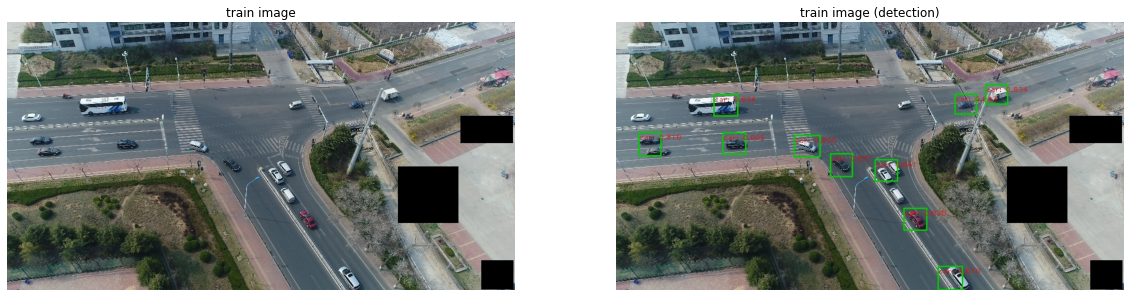

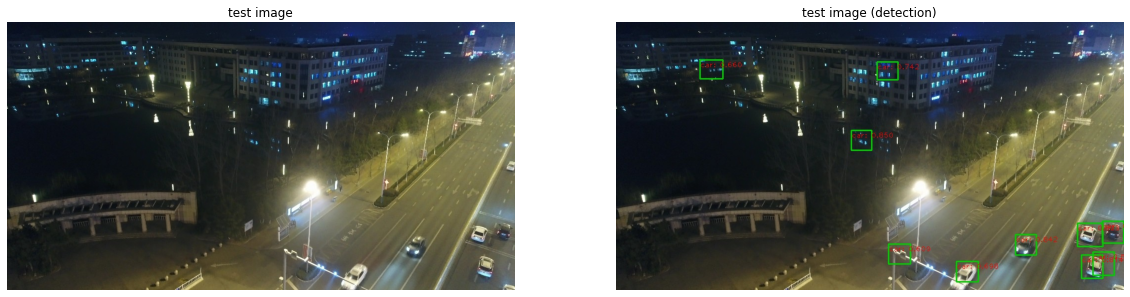

In [21]:
#--------------------------------------------------
#    You need to get detection result images here
#--------------------------------------------------
import matplotlib.pyplot as plt

# read the image for local directory (same with this .ipynb) 
img1 = cv2.imread('images/img0.jpg')
img2 = cv2.imread('images/img2.jpg')

img1_det = cv2.imread('images/img0_det.jpg')
img2_det = cv2.imread('images/img2_det.jpg')

# Be sure to convert the color space of the image from
# BGR (Opencv) to RGB (Matplotlib) before you show a 
# color image read from OpenCV
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title('train image')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img1_det, cv2.COLOR_BGR2RGB))
plt.title('train image (detection)')
plt.axis("off")

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title('test image')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img2_det, cv2.COLOR_BGR2RGB))
plt.title('test image (detection)')
plt.axis("off")

plt.show()

### Discussion:
(15 points) 

1. Compare your detection results with ground-truth. Is it good or bad? In what aspects. 

[your answer]: The results are not perfect. We can see that most of the cars have been detected as cars, but some cars were not detected. What's more, the bounty boxes didn't always capture the objects perfectly, some captured only half of the cars. 

Another problem is that there were instances where there were multiple detections of the same object or one box captured more than one object.

After running the code several times I noticed that the results fluctuated wildly, so the detection results are not as good as always.



2. Which hyper-parameters during training stage or properties of dataset would affect the detection results most by your understanding?

[your answer]: I think some important ones for the bounty boxes are: ROI pooling kernel, threshold, feature extractor, regression type, and anchor scale and ratios. Some important ones for the network training are the learning rate, regularization, optimizer, and batch size.

The anchor scale and ratio values may affect detection results the most, since we create the anchors that will be used for classification. Maybe we could get better results if the anchor is more accurately fits the vehicle in question. Also, we can adjust the threshold, optimizer, and batch size to get a better result. 



## Submission guidelines
---
Extract the downloaded .zip file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them, (we assume that 'Surname_Givenname_SBUID_hw5' is your working directory, and all the paths are relative to this directory).  The image read and write functions are already written for you. All you need to do is to fill in the blanks as indicated to generate proper outputs. **DO NOT** zip and upload the dataset on blackboard due to size limit.

When submitting your .zip file through blackboard, please
-- name your .zip file as **Surname_Givenname_SBUID_hw*.zip**.

This zip file should include:
```
Surname_Givenname_SBUID_hw*
        |---Surname_Givenname_SBUID_hw*.ipynb
        |---Surname_Givenname_SBUID_hw*.pdf
```

For instance, student Yann LeCun should submit a zip file named "LeCun_Yann_111134567_hw5.zip" for homework5 in this structure:
```
LeCun_Yann_111134567_hw5
        |---LeCun_Yann_111134567_hw5_p1.ipynb
        |---LeCun_Yann_111134567_hw5_p2.ipynb
        |---LeCun_Yann_111134567_hw5.pdf
```

The **Surname_Givenname_SBUID_hw*.pdf** should include a **google shared link**. To generate the **google shared link**, first create a folder named **Surname_Givenname_SBUID_hw*** in your Google Drive with your Stony Brook account. The structure of the files in the folder should be exactly the same as the one you downloaded. If you alter the folder structures, the grading of your homework will be significantly delayed and possibly penalized.

Then right click this folder, click ***Get shareable link***, in the People textfield, enter TA's email: ***kgarigapati@cs.stonybrook.edu***. Make sure that TAs who have the link **can edit**, ***not just*** **can view**, and also **uncheck** the **Notify people** box.

Colab has a good feature of version control, you should take advantage of this to save your work properly. However, the timestamp of the submission made in blackboard is the only one that we consider for grading. To be more specific, we will only grade the version of your code right before the timestamp of the submission made in blackboard. 

You are encouraged to post and answer questions on Piazza. Based on the amount of email that we have received in past years, there might be dealys in replying to personal emails. Please ask questions on Piazza and send emails only for personal issues.

Be aware that your code will undergo plagiarism check both vertically and horizontally. Please do your own work.

**Late submission penalty:** <br>
There will be a 10% penalty per day for late submission. However, you will have 3 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period.